In [1]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv

def extract_points_from_path(path_segment, num_samples=100):
    if isinstance(path_segment, (Line, CubicBezier, QuadraticBezier, Arc)):
        return [path_segment.point(t) for t in np.linspace(0, 1, num_samples)]
    return []

svg_file = './data/problems/frag2.svg' 
paths, _ = svg2paths(svg_file)

all_points = []
for curve_index, path in enumerate(paths):
    for segment in path:
        points = extract_points_from_path(segment)
        all_points.extend([(curve_index, 0.0000, float(p.real), float(p.imag)) for p in points])

with open('out.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'constant', 'x', 'y'])
    for index, constant, x, y in all_points:
        writer.writerow([index, constant, np.float64(x), np.float64(y)])


FileNotFoundError: [Errno 2] No such file or directory: '/home/aarya/Downloads/data/problems/frag2.svg'

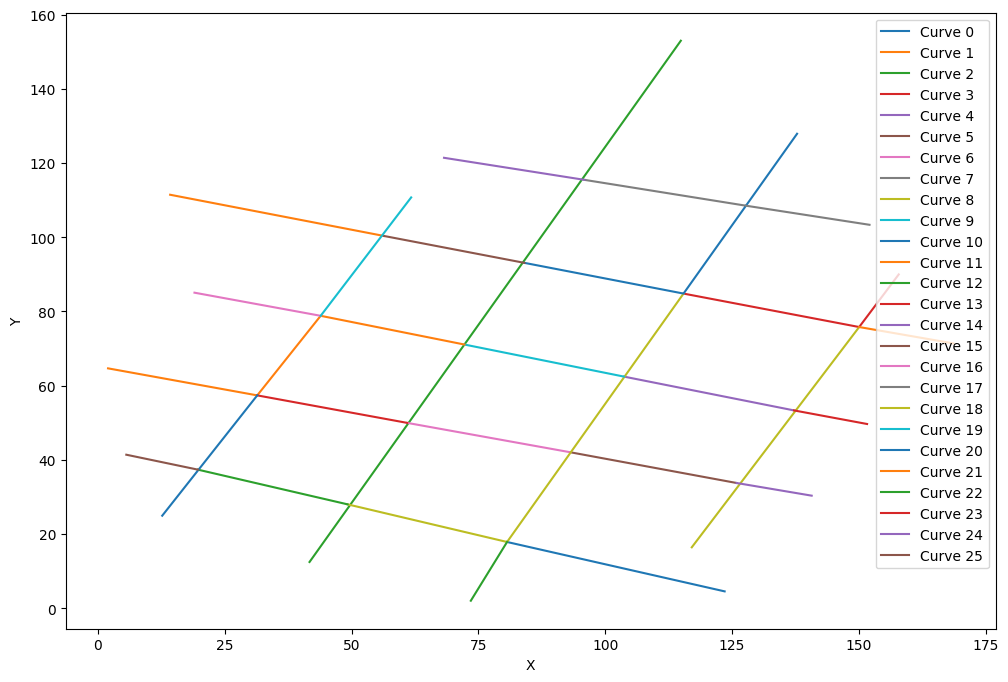

In [2]:
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

def euclidean_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    return np.linalg.norm(point1 - point2)

def rdp(points: np.ndarray, epsilon: float) -> List[Tuple[float, float]]:
    dmax = 0
    index = 0
    end = len(points)
    for i in range(1, end - 1):
        d = euclidean_distance(points[i], points[0]) + euclidean_distance(points[i], points[-1]) - euclidean_distance(points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        results1 = rdp(points[:index + 1], epsilon)
        results2 = rdp(points[index:], epsilon)
        return results1[:-1] + results2
    else:
        return [tuple(points[0]), tuple(points[-1])]

def average_close_vertices(curves: defaultdict, tolerance: float) -> defaultdict:
    all_points = []
    for points in curves.values():
        all_points.extend(points)

    clusters = []
    for point in all_points:
        added = False
        for cluster in clusters:
            if any(euclidean_distance(np.array(cp), np.array(point)) <= tolerance for cp in cluster):
                cluster.append(point)
                added = True
                break
        if not added:
            clusters.append([point])

    averaged_points = {}
    for cluster in clusters:
        avg_point = tuple(np.mean(cluster, axis=0))
        for point in cluster:
            averaged_points[point] = avg_point

    new_curves = defaultdict(list)
    for curve_no, points in curves.items():
        new_points = [averaged_points[point] for point in points]
        new_curves[curve_no] = new_points

    return new_curves

curves = defaultdict(list)

# Load the CSV data
with open('out.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  
    for row in reader:
        try:
            curve_no = int(float(row[0])) 
            x = float(row[2])
            y = float(row[3])
            curves[curve_no].append((x, y))
        except ValueError as e:
            print(f"Skipping line due to error: {e}")

epsilon_initial = 1.5  
simplified_curves = defaultdict(list)
for curve_no, points in curves.items():
    points_array = np.array(points)
    simplified_points = rdp(points_array, epsilon_initial)
    simplified_curves[curve_no] = simplified_points

tolerance = 5  
averaged_curves = average_close_vertices(simplified_curves, tolerance)

epsilon_final = 1.5 
final_curves = defaultdict(list)
for curve_no, points in averaged_curves.items():
    points_array = np.array(points)
    final_points = rdp(points_array, epsilon_final)
    final_curves[curve_no] = final_points

plt.figure(figsize=(12, 8))
for curve_no, points in final_curves.items():
    final_points_x, final_points_y = zip(*points)
    plt.plot(final_points_x, final_points_y, label=f'Curve {curve_no}')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
